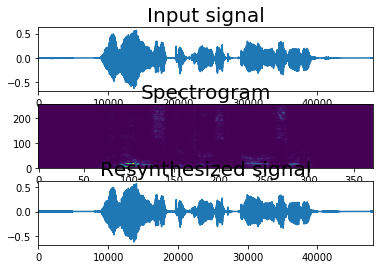

In [8]:
# -*- coding: utf-8 -*-
# ==================================
#
#    Short Time Fourier Trasform
#
# ==================================
from scipy import ceil, complex64, float64, hamming, zeros
from scipy.fftpack import fft# , ifft
from scipy import ifft # こっちじゃないとエラー出るときあった気がする

import soundfile as sf

from matplotlib import pylab as pl


def stft(x, win, step):
    l = len(x) # 入力信号の長さ
    N = len(win) # 窓幅、つまり切り出す幅
    M = int(ceil(float(l - N + step) / step)) # スペクトログラムの時間フレーム数
    
    new_x = zeros(N + ((M - 1) * step), dtype = float64)
    new_x[: l] = x # 信号をいい感じの長さにする
    
    X = zeros([M, N], dtype = complex64) # スペクトログラムの初期化(複素数型)
    for m in range(M):
        start = step * m
        X[m, :] = fft(new_x[start : start + N] * win)
    return X

# =======
#  iSTFT
# =======
def istft(X, win, step):
    M, N = X.shape
    assert (len(win) == N), "FFT length and window length are different."

    l = (M - 1) * step + N
    x = zeros(l, dtype = float64)
    wsum = zeros(l, dtype = float64)
    for m in range(M):
        start = step * m
        ### 滑らかな接続
        x[start : start + N] = x[start : start + N] + ifft(X[m, :]).real * win
        wsum[start : start + N] += win ** 2 
    pos = (wsum != 0)
    x_pre = x.copy()
    ### 窓分のスケール合わせ
    x[pos] /= wsum[pos]
    return x


if __name__ == "__main__":
    #wavfile = "./aiueo.wav"
    #fs, data = read(wavfile)
    data, fs = \
    sf.read('/Users/admin/Desktop/practiceunderpycharm/flac_dataforcnn/10005.flac')
    data = data[:16000 * 3]


    fftLen = 512 # とりあえず
    win = hamming(fftLen) # ハミング窓
    step = int(fftLen / 4)

    ### STFT
    spectrogram = stft(data, win, step)

    ### iSTFT
    resyn_data = istft(spectrogram, win, step)

    ### Plot
    fig = pl.figure()
    fig.add_subplot(311)
    pl.plot(data)
    pl.xlim([0, len(data)])
    pl.title("Input signal", fontsize = 20)
    fig.add_subplot(312)
    pl.imshow(abs(spectrogram[:, : int(fftLen / 2 + 1)].T), aspect = "auto", origin = "lower")
    pl.title("Spectrogram", fontsize = 20)
    fig.add_subplot(313)
    pl.plot(resyn_data)
    pl.xlim([0, len(resyn_data)])
    pl.title("Resynthesized signal", fontsize = 20)
    pl.show()